# Todays News Trends

### Program gets the current to headlines from 
*All News Media*
### and performs sentiment analysis on the news to identify the current sentiment.

In [3]:
# Dependencies
import string
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import requests

from pprint import pprint

%matplotlib inline

# News API
import newsapi
from newsapi.newsapi_client import NewsApiClient
from newsapi.articles import Articles
from newsapi.sources import Sources

# NLTK
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#word cloud
from wordcloud import WordCloud

In [4]:
# Twitter API Keys
from config import (consumer_key, consumer_secret, access_token, access_token_secret)
#News API Keys
from config import newapi_key

In [5]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#from config import (consumer_key, consumer_secret,
#                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Init
newsapi = NewsApiClient(api_key='4b7e7bb7670e40f788f92667a6a2dd64')
newsapi_Articles = Articles(API_KEY=newapi_key)
newsapi_Sources = Sources(API_KEY=newapi_key)

### Method: getCurrentHeadlines() 
### Get the top headlines from newsapi. 
Default value country=US, lanuage=english, page_size=100 (max allowed) <br/>
Other paramers like q (query), sources, categories and pages can be passed in.

##### Note: country and category params cannot be used with sources param
*Category possible values:* 'business','entertainment','general','health','science','sports','technology'

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [6]:
def getCurrentHeadlines(q=None, 
                        sources=None, 
                        language='en', 
                        country='us', 
                        category=None, 
                        page_size=100, 
                        page=None):
    if(sources != None):
        country = None
        category = None
        
    print(f"Calling => getCurrentHeadlines(q={q}, \n\
                                sources={sources},\n\
                                language={language},\n\
                                country={country},\n\
                                category={category},\n\
                                page_size={page_size},\n\
                                page={page})")

    results = newsapi.get_top_headlines(q, 
                                              sources, 
                                              language, 
                                              country, 
                                              category, 
                                              page_size, 
                                              page)
    results_count = results['totalResults'] 
    # return value
    top_headlines = results['articles']
    
    # the first 100 has already been pulled in the first call, 
    # so start pulling from page 2
    loopcount = int(results_count / 100)
    page = 2
    
    while(loopcount > 0):
        #print('INSIDE LOOP')
        #print(f"output list size = {len(top_headlines)}")
        
        results = None
        results = newsapi.get_top_headlines(q, 
                                          sources, 
                                          language, 
                                          country, 
                                          category, 
                                          page_size, 
                                          page)
        #print(f"page {page} pulled {results['totalResults']}")
        #print(f"loopcount {loopcount} pulled {len(results['articles'])}")
        
        top_headlines = top_headlines + results['articles']
        page += 1
        loopcount -= 1
        
        # break at 500 articles
        if(page > 5):
            break
         
    print(f"totalResults from newsapi.get_top_headlines() = {results_count} \n \
          top_headlines returned by the method = {len(top_headlines)}")
    return top_headlines

**Call Details**

*Default value country=US, lanuage=english, page_size=100
Other paramers like q (query), sources, categories and pages can be passed in.*

##### Note: country and category params cannot be used with sources param
Category possible values: 'business','entertainment','general','health','science','sports','technology'

*Sample:* 

**Correct Call:**

getCurrentHeadlines() *returns top headlines for US, English* <br/>
getCurrentHeadlines(sources='bbc-news') *returns top headlines from bbc-news, English*<br/>
getCurrentHeadlines(category='sports') *returns top headlines for sports, in English (not restricted to US)* <br/>
getCurrentHeadlines(q='FIFA World Cup', country=None) *returns top headlines for sports, in English (not restricted to US)* <br/>

**Incorrect Call: Category will be made None because sources is set.**

getCurrentHeadlines(sources='bbc-news', *'category='sports'*)

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [7]:
news_sources = 'google-news,abc-news,cbs-news,cnbc,bbc-news,cnn,fox-news, \
                nbc-news,the-washington-post,the-washington-times'
headlines = getCurrentHeadlines(sources=news_sources)
#headlines = getCurrentHeadlines(country=None)
#headlines = getCurrentHeadlines()

Calling => getCurrentHeadlines(q=None, 
                                sources=google-news,abc-news,cbs-news,cnbc,bbc-news,cnn,fox-news,                 nbc-news,the-washington-post,the-washington-times,
                                language=en,
                                country=None,
                                category=None,
                                page_size=100,
                                page=None)
totalResults from newsapi.get_top_headlines() = 99 
           top_headlines returned by the method = 99


In [14]:
#pprint(headlines)

In [8]:
type(headlines)

list

In [9]:
news_top_headlines_df = pd.DataFrame(headlines)

In [18]:
#news_top_headlines_df.head()

In [10]:
news_channel_name_list = [article['source']['name'] for article in headlines]

**News Channel Name List**

In [11]:
news_top_headlines_df['News Channel'] = news_channel_name_list

In [12]:
news_top_headlines_df.head(3)

,author,description,publishedAt,source,title,url,urlToImage,News Channel
0,"Phil Gast, CNN",Canadian Prime Minister Justin Trudeau has res...,2018-07-03T01:52:54.1147107Z,"{'id': 'cnn', 'name': 'CNN'}",Justin Trudeau about groping claim from 18 yea...,http://us.cnn.com/2018/07/02/americas/justin-t...,https://cdn.cnn.com/cnnnext/dam/assets/1805311...,CNN
1,"Ben Geldon, CNN",Here are the stories our D.C. insiders are tal...,2018-07-03T01:52:53.4584877Z,"{'id': 'cnn', 'name': 'CNN'}",How Scott Pruitt keeps his job,http://us.cnn.com/2018/06/17/politics/ip-why-p...,https://cdn.cnn.com/cnnnext/dam/assets/1806171...,CNN
2,None,Some conservatives are now calling for embattl...,2018-07-03T01:52:52.770964Z,"{'id': 'cnn', 'name': 'CNN'}",Conservatives turn on embattled EPA chief - CN...,http://us.cnn.com/videos/politics/2018/06/14/g...,https://cdn.cnn.com/cnnnext/dam/assets/1804091...,CNN


## Word Count 

### sentence preprocessing into cleaned strings

In [13]:
def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in string.punctuation]
    stopw = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopw]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word)>=3]
    #lower capitalization
    tokens = [word.lower() for word in tokens]
    # lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [14]:
def generteWordCloud(text_as_strings):
    wordcloud = WordCloud().generate(text_as_strings)
    
    #Print the word cloud
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud.recolor(random_state=2017))
    plt.title('Top Headline Words')
    plt.axis("off")
    plt.show()

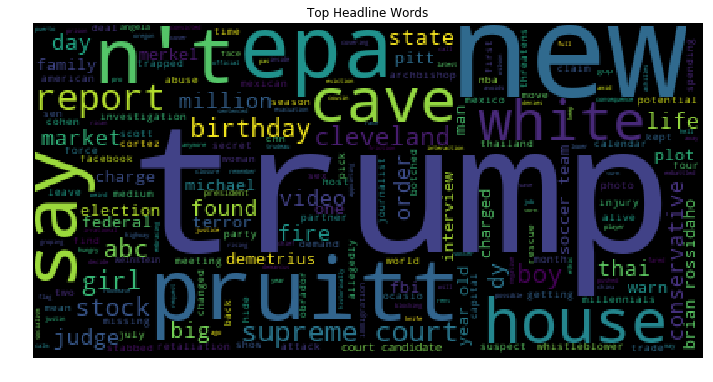

In [15]:
headline_words = ''

for title in news_top_headlines_df['title']:
    headline_words = headline_words + ' ' + preprocessing(title)

generteWordCloud(headline_words)

## Generate word frequency

In [16]:
def generateWordFrequency(text_as_strings):
    #print(text_as_strings)
    tokens = text_as_strings.split(" ")
    
    freq = {}

    for i in tokens:
        
        if i in freq:
            freq[i] += 1
        else:
            freq[i] = 1
    
    return freq
    
#print(freq)

In [17]:
generateWordFrequency(headline_words)

{'': 1,
 'justin': 1,
 'trudeau': 1,
 'groping': 1,
 'claim': 2,
 'year': 1,
 'ago': 1,
 "n't": 5,
 'remember': 1,
 'negative': 1,
 'interaction': 1,
 'how': 6,
 'scott': 2,
 'pruitt': 6,
 'keep': 1,
 'job': 1,
 'conservative': 3,
 'turn': 1,
 'embattled': 1,
 'epa': 6,
 'chief': 1,
 'cnn': 2,
 'video': 3,
 'possible': 1,
 'retaliation': 2,
 'investigation': 2,
 'why': 1,
 'may': 1,
 'getting': 2,
 'pas': 1,
 'ethic': 1,
 'official': 1,
 'pushed': 1,
 'whistleblower': 2,
 'kept': 2,
 'secret': 2,
 'calendar': 2,
 'hide': 2,
 'meeting': 2,
 'judge': 3,
 'decide': 1,
 'order': 3,
 'blocking': 1,
 'puerto': 1,
 'rican': 1,
 'eviction': 1,
 'demarcus': 1,
 'cousin': 1,
 'injury': 2,
 'nba': 2,
 'player': 1,
 'historically': 1,
 'fared': 1,
 'torn': 1,
 'achilles': 1,
 'the': 6,
 'consequence': 1,
 'millennials': 2,
 'embracing': 1,
 'socialism': 1,
 'latest': 1,
 'oregon': 1,
 'fire': 3,
 'force': 2,
 'evacuation': 1,
 'highway': 1,
 'closure': 1,
 'china': 1,
 'state': 3,
 'medium': 2,
 '

## Getting Sentiment Analysis for Headlines 
**Sentiment Analysis** <br/>
*Using vaderSentiment Analyzer to analize the new media sentiment from the headline*

### getSentiments Method
### Input: Dataframe returned by getCurrentHeadlines() call
### Return: sentiment list
#### Sentiment parameters
    "Headlines", 
    "Channel",
    "Compound",
    "Positive",
    "Negative",
    "Neutral"

In [19]:
def getSentiments(df):
    sentiments = []

    for index, row in df.iterrows():

        words = preprocessing(row['title'])

        # Run Vader Analysis on each headline
        results = analyzer.polarity_scores(words)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add sentiments for each tweet into a list
        sentiments.append({"Headlines": row['title'], 
                           "Channel": row['News Channel'],
                           "Compound": compound,
                           "Positive": pos,
                           "Negative": neu,
                           "Neutral": neg})
        
    return sentiments

In [20]:
sentiments = getSentiments(news_top_headlines_df)

In [21]:
sentiments

[{'Headlines': "Justin Trudeau about groping claim from 18 years ago: 'I don't remember any negative interactions'",
  'Channel': 'CNN',
  'Compound': 0.4585,
  'Positive': 0.25,
  'Negative': 0.75,
  'Neutral': 0.0},
 {'Headlines': 'How Scott Pruitt keeps his job',
  'Channel': 'CNN',
  'Compound': 0.0,
  'Positive': 0.0,
  'Negative': 1.0,
  'Neutral': 0.0},
 {'Headlines': 'Conservatives turn on embattled EPA chief - CNN Video',
  'Channel': 'CNN',
  'Compound': 0.0,
  'Positive': 0.0,
  'Negative': 1.0,
  'Neutral': 0.0},
 {'Headlines': 'Possible retaliation at EPA under investigation',
  'Channel': 'CNN',
  'Compound': 0.0,
  'Positive': 0.0,
  'Negative': 1.0,
  'Neutral': 0.0},
 {'Headlines': 'Why Scott Pruitt may be getting a pass - CNN Video',
  'Channel': 'CNN',
  'Compound': 0.0,
  'Positive': 0.0,
  'Negative': 1.0,
  'Neutral': 0.0},
 {'Headlines': 'EPA ethics official pushed for Pruitt investigations',
  'Channel': 'CNN',
  'Compound': 0.0,
  'Positive': 0.0,
  'Negative':

In [22]:
df = pd.DataFrame(sentiments)

In [23]:
df

,Channel,Compound,Headlines,Negative,Neutral,Positive
0,CNN,0.4585,Justin Trudeau about groping claim from 18 yea...,0.750,0.000,0.250
1,CNN,0.0000,How Scott Pruitt keeps his job,1.000,0.000,0.000
2,CNN,0.0000,Conservatives turn on embattled EPA chief - CN...,1.000,0.000,0.000
3,CNN,0.0000,Possible retaliation at EPA under investigation,1.000,0.000,0.000
4,CNN,0.0000,Why Scott Pruitt may be getting a pass - CNN V...,1.000,0.000,0.000
5,CNN,0.0000,EPA ethics official pushed for Pruitt investig...,1.000,0.000,0.000
6,CNN,-0.1779,Whistleblower: EPA's Pruitt kept secret calend...,0.805,0.195,0.000
7,CBS News,-0.6808,Judge to decide on order blocking Puerto Rican...,0.472,0.528,0.000
8,Google News,-0.5859,DeMarcus Cousins injury: How NBA players histo...,0.625,0.375,0.000
9,Fox News,0.0000,The consequences of millennials embracing soci...,1.000,0.000,0.000


#  CODE BELOW IS NICK's

In [ ]:
# remove the stopwords
remove_words = ['the', 'an', 'a', 'is', 'i', 'and', 'then', 'like', 'there', 'their']

In [ ]:
#remove the punctuation
def remove_punctuation(chars):
    return ''.join([c for c in chars if c not in punctuation])

# The DataFrame is 'news_top_headlines_df'
df = news_top_headlines_df

In [ ]:
#import our dataframe

df =

In [ ]:
#tokenize the text within the dataframe
df.loc[:, 'text_split'] = df.text.map(sent_tokenize)

In [ ]:
#get the text ready to analyze
sentences = []
for _, r in df.iterrows():
    for s in r("Headline").text_split:
        filtered_words = [remove_punctuation(w) for w in s.split() if w.lower() not in remove_words]
        # or using nltk.word_tokenize
        # filtered_words = [w for w in word_tokenize(s) if w.lower() not in remove_words and w not in punctuation]
        sentences.append({'sent_id': r.sent_id, 
                          'text': s.strip('.'), 
                          'words': filtered_words})
    wordfrq = r("Headline").text_split()

In [ ]:
#masterlist
masterlist = []

for channel in df:
    masterlist.append({'Channel': wordfrq})

In [ ]:
#rename the dataframe
df_words = pd.DataFrame(sentences)

In [ ]:
#word_cloud
#word freq
freq = nltk.FreqDist(wordfrq)
#tfidf
#stemming
#limitization
#thematic analysis

In [ ]:
#start the vader analysis
#run the vader on the orginal text
#import vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()